### Importing libraries and getting the required columns from database

In [1]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import linear_model
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
import getpass

warnings.filterwarnings("ignore")

# password = getpass.getpass()

#### Connecting to database and importing just the columns we need.

In [2]:
password = 'iron'

connection_string = 'mysql+pymysql://root:' + password + '@localhost/fire_db'
engine = create_engine(connection_string)

query = '''select lat, lon,duration, area_total, alert_date,relative_humidity,wind_intensity,precipitation, ffmc, 
        dc,isi,dmc,avg_altitude,avg_inclination,rvdendity,cosn5variety 
        from 
        fires_clean 
        where district in ('Vila Real')'''

model_dataset = pd.read_sql_query(query, engine)

##### Columns description

We are not including district since it's directly correlated to the gps coordinates

+ lat: Latitude
+ lon: Longitude
+ duration: Duration of fire in hours
+ areal_total: Total Area burned ( Our target )
+ alert_date: Date of the alert, we are going to transform it to the day of the year and drop it.
+ relative_humitity: Relative humitity
+ wind_intensity: Wind Intensity
+ precipitation: Precipitation 
+ ffmc: The Fine Fuel Moisture Code, range 0-99
+ dmc: The Duff Moisture Code, range 0-350
+ dc: The Drought Code, range 0-1200
+ isi:The Initial Spread Index
+ avg_altitude: Average altitude
+ avg_inclination: Average inclination ( correlated with easy access to the fire )
+ rvdendity: Specific internal variable
+ cosn5variety: Specific internal variable


### Preparing dataset to be modeled

In [3]:
model_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
lat,7336.0,41.560236,0.197781,41.125295,41.400239,41.605624,41.723815,41.915278
lon,7336.0,-7.665206,0.214976,-8.108611,-7.835833,-7.688663,-7.492427,-7.178611
duration,7336.0,23.685722,128.491946,0.020000,0.650000,1.080000,2.080000,2215.700000
area_total,7336.0,9.947530,106.060018,0.000000,0.020000,0.350000,1.500000,4576.540000
relative_humidity,7336.0,44.061857,15.229540,0.000000,33.000000,42.000000,53.000000,100.500000
wind_intensity,7336.0,7.547859,4.900238,0.000000,4.000000,7.000000,10.000000,41.620000
precipitation,7336.0,0.091439,0.941001,0.000000,0.000000,0.000000,0.000000,36.000000
ffmc,7336.0,88.427045,7.501914,0.000000,86.900000,89.800000,92.030000,101.000000
dc,7336.0,417.307888,317.316468,0.040000,78.000000,472.550000,673.000000,3315.530000
isi,7336.0,6.475226,3.750749,0.000000,3.960000,6.200000,8.500000,100.700000


#### From the describe we can see that ffmc has a max value of 3525, wich is invalid because it only ranges from 0-99, dmc has values into 1590's and it only ranges from 0 to 350 and dc has values up to 3315 and the maximum allowed is 1200. Those rows have all to be discarded. The isi is within range since is calculated with ffmc and the winds.

In [4]:
model_dataset = model_dataset[model_dataset['ffmc']<100]
model_dataset = model_dataset[model_dataset['dmc']<350]
model_dataset = model_dataset[model_dataset['dc']<1200]

In [5]:
model_dataset.shape

(7212, 16)

#### Creating a day of the year column from the alert date, then we drop the original columns since it's not needed

In [6]:
model_dataset['doy'] = model_dataset['alert_date'].apply(lambda x: x.strftime('%j')).astype(np.number)
model_dataset = model_dataset.drop(['alert_date'], axis = 1)

#### Checking for distribuitions

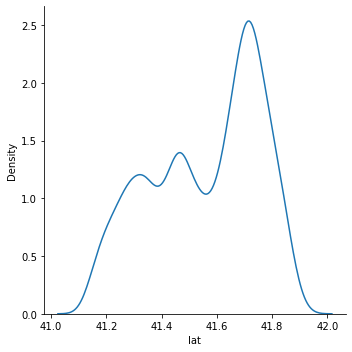

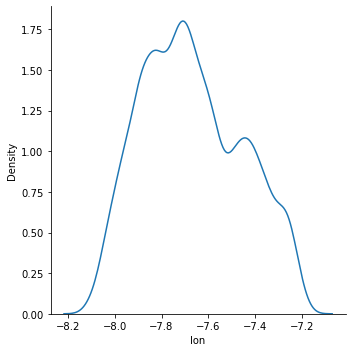

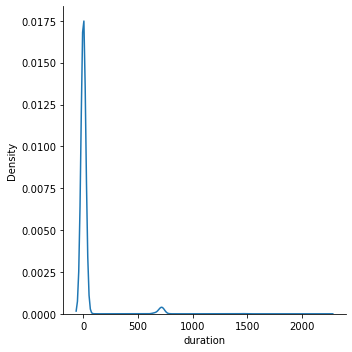

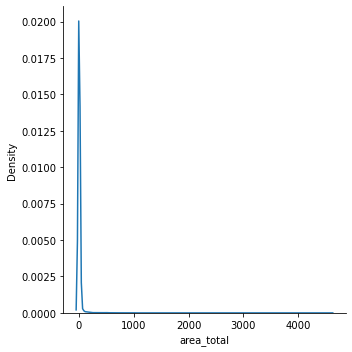

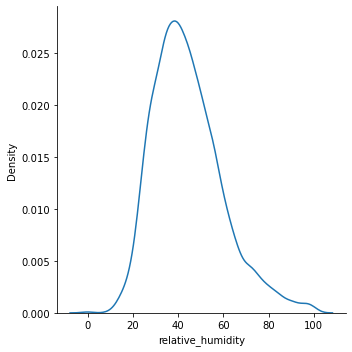

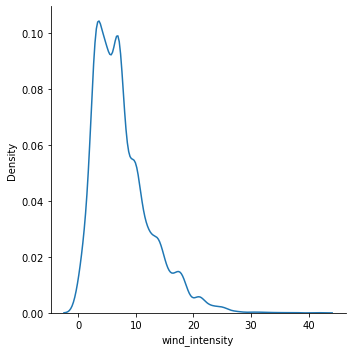

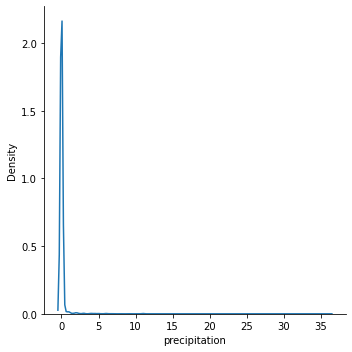

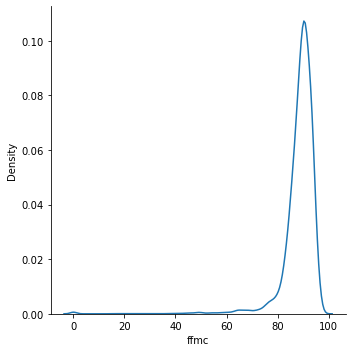

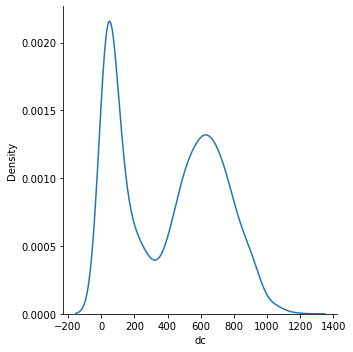

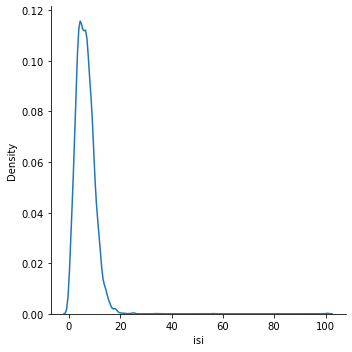

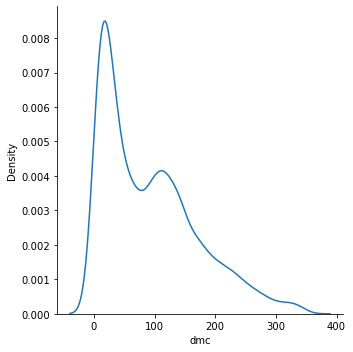

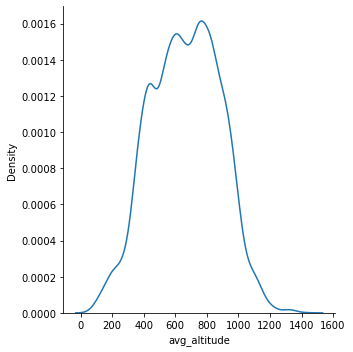

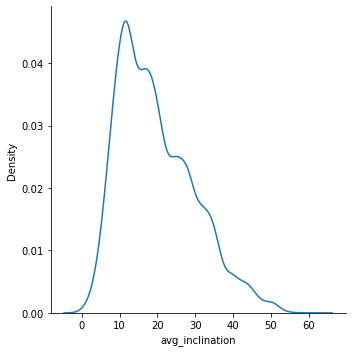

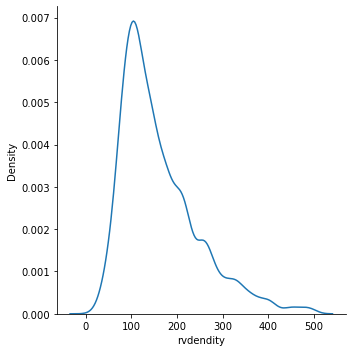

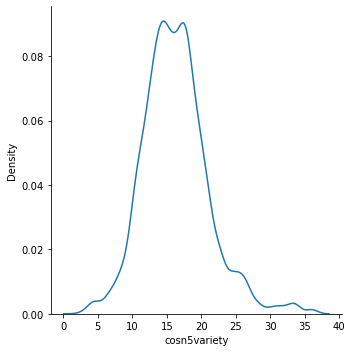

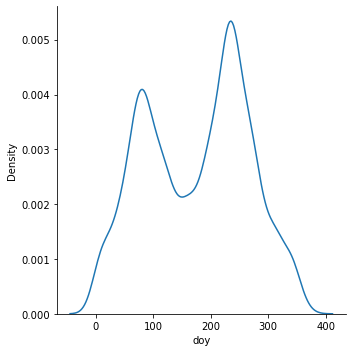

In [7]:
# Ploting every column
for i in model_dataset.columns:
    sns.displot(data=model_dataset, x=i, kind = 'kde')

##### Log encode
Some data is really skewd and awkward.
Since we are going to use MLP regressor and Random Forest we will log encode our target to achieve a better performance.
We are also going to log encode isi, precipitation and wind density.

In [8]:
log_list = ['isi','precipitation', 'wind_intensity', 'area_total']
model_dataset.loc[:, log_list] = model_dataset.loc[:, log_list].apply(lambda x: np.log(x + 1), axis = 1)

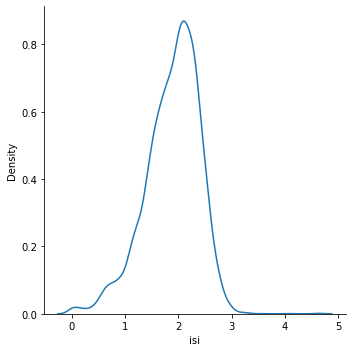

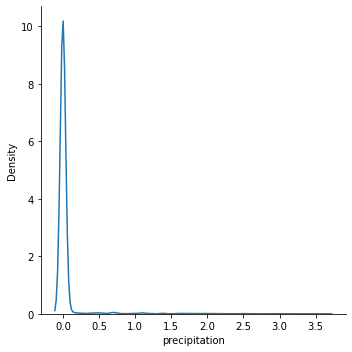

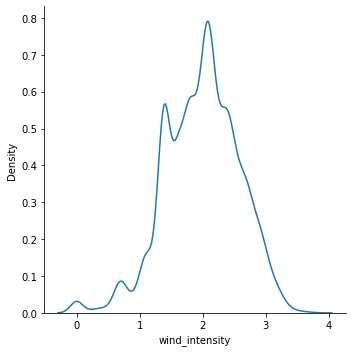

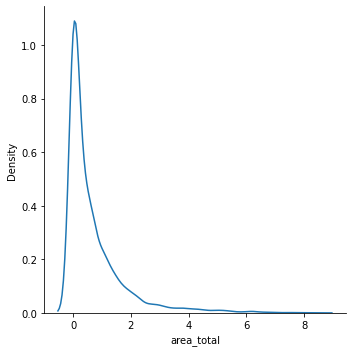

In [9]:
for i in log_list:
    sns.displot(data=model_dataset, x=i, kind = 'kde')

We have better distribuition, not ideal normal distribuition but an improvement.

In [10]:
display(model_dataset.head(2))
model_dataset.describe().T

,lat,lon,duration,area_total,relative_humidity,wind_intensity,precipitation,ffmc,dc,isi,dmc,avg_altitude,avg_inclination,rvdendity,cosn5variety,doy
0,41.346620,-7.621749,0.5,0.262364,50.0,3.258097,0.0,85.1,9.4,2.151762,3.8,808.6,12.36,164.72,19.29,214.0
1,41.230196,-7.792019,0.6,0.000000,50.0,3.258097,0.0,85.1,9.4,2.151762,3.8,423.5,43.65,167.20,13.00,214.0


,count,mean,std,min,25%,50%,75%,max
lat,7212.0,41.559963,0.198316,41.125295,41.398268,41.605833,41.723889,41.915278
lon,7212.0,-7.669266,0.213930,-8.108611,-7.836944,-7.692842,-7.501319,-7.178611
duration,7212.0,23.251298,127.475829,0.020000,0.650000,1.080000,2.080000,2215.700000
area_total,7212.0,0.683038,1.037396,0.000000,0.019803,0.300105,0.916291,8.428917
relative_humidity,7212.0,44.201410,15.266046,0.000000,33.000000,42.000000,53.000000,100.500000
wind_intensity,7212.0,1.987083,0.582257,0.000000,1.609438,2.079442,2.397895,3.752324
precipitation,7212.0,0.033326,0.221708,0.000000,0.000000,0.000000,0.000000,3.610918
ffmc,7212.0,88.435403,7.102045,0.000000,86.800000,89.795000,92.000000,97.700000
dc,7212.0,406.769168,303.006300,0.040000,76.050000,463.820000,665.600000,1193.900000
isi,7212.0,1.890479,0.503706,0.000000,1.589235,1.960095,2.251292,4.622027


In [11]:
model_dataset = model_dataset.dropna()

### X-y Split

In [12]:
from sklearn.model_selection import train_test_split

target =['area_total']

y = model_dataset[target]
X = model_dataset.drop(target, axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#### Min-max scaling
Note: we are not spliting by categorical and numerical because we just have numerical continuous labels

In [13]:
# MinMax function to normalize continuous columns 
def minmax_scaler(data, _transformer):
    X_normalized = _transformer.transform(data)
    return pd.DataFrame(X_normalized, columns=data.columns)

In [14]:
# Creating and fitting our transformer that will work for train and test splits
transformer = MinMaxScaler().fit(X_train)

X_train = minmax_scaler(X_train, transformer)
X_test = minmax_scaler(X_test, transformer)

Everything is now normalized to the range 0-1

In [15]:
X_train.head()

,lat,lon,duration,relative_humidity,wind_intensity,precipitation,ffmc,dc,isi,dmc,avg_altitude,avg_inclination,rvdendity,cosn5variety,doy
0,0.906589,0.778259,0.001106,0.427861,0.477507,0.0,0.912821,0.530497,0.380322,0.360609,0.299133,0.234470,0.142133,0.259601,0.616438
1,0.632839,0.834964,0.000352,0.378109,0.554174,0.0,0.927179,0.634603,0.438801,0.926787,0.411601,0.120737,0.326426,0.479012,0.638356
2,0.758589,0.746393,0.000226,0.266667,0.715225,0.0,0.951897,0.463836,0.519190,0.310709,0.395487,0.299908,0.290128,0.481691,0.534247
3,0.207172,0.241910,0.000478,0.686567,0.369450,0.0,0.819487,0.164159,0.180204,0.020098,0.590605,0.507650,0.377585,0.469783,0.115068
4,0.509233,0.527610,0.000217,0.477612,0.784698,0.0,0.922051,0.663236,0.528415,0.372954,0.420172,0.204424,0.339467,0.333433,0.734247


#### Check for unwanted correlations

<AxesSubplot:>

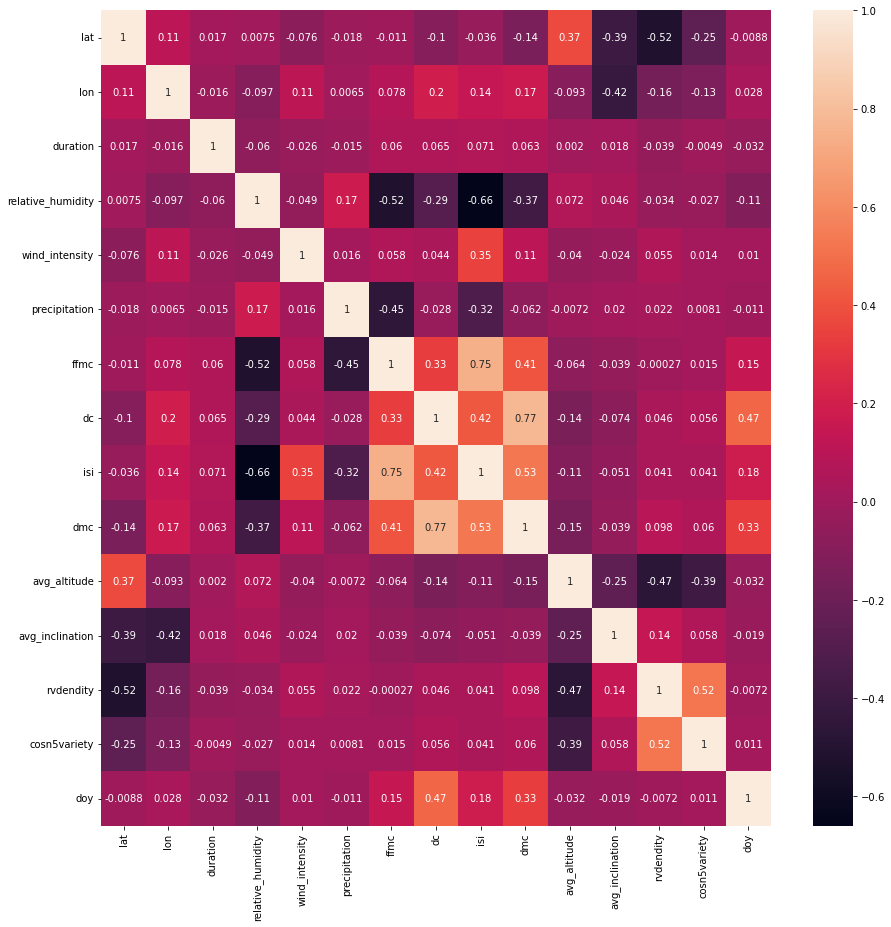

In [16]:
plt.figure(figsize = (len(X_train.columns),len(X_train.columns)))
correlations_matrix = X_train.corr()
sns.heatmap(correlations_matrix, annot=True)

#### Creating a functions that just plots results

In [17]:
# Arguments original = y_test(real test values), predicted = predictions
def plot_predictions(original,predicted):
    
    # Ploting 2 plots comparing the real results and predictions
    fig, ax = plt.subplots(1, 2)
    
    print("RED - Real data")
    print("GREEN - Predictid values")

    sns.distplot(original, hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 2},
                color ="red", ax = ax[0])

    sns.distplot(predicted, hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 2},
                color ="green", ax = ax[1])
    
    # rescaling the subplots
    fig.set_figheight(5)
    fig.set_figwidth(10)
    plt.show()  
    
    return None

#### Creating a function to build our models and present results.

+ Arguments

    - X_train, X_test, y_train, y_test: Subsets needed to build the models
    - pick: True if user wants to save models, default False
    - rnd: randomizer nodes for MLP Regressor
    - itr: number of iterations for models
    
+ Returns

    - res: array of real and model results
    - mlp and rfr: objects containing the fitted models

In [18]:
def multi_model(X_train, X_test, y_train, y_test,pick = False, itr= 400):
    
    # Creating the model objects, so we can return a valid model even if only one model is selected
    results = []
    results.append(list(y_test['area_total']))
    reg = ExtraTreesRegressor(n_estimators=itr, random_state=1).fit(X_train, y_train)
    rfr = RandomForestRegressor(n_estimators = itr, n_jobs = -1).fit(X_train, y_train)
    
    
    # Going through all the required models, fitting and printing results
    predictions_reg = reg.predict(X_test)
    print('Extra Tree Regressor regression Predictions R2 :', round(r2_score(y_test, predictions_reg),2)*100, '|',round(reg.score(X_train, y_train),2)*100,'  Train Score\n' )
    results.append(predictions_reg)
    plot_predictions(y_test, predictions_reg)
    
    predictions_rfr = rfr.predict(X_test)
    print(' Forest Regressor regression Predictions R2 :', round(r2_score(y_test, predictions_rfr),2)*100, '|',round(rfr.score(X_train, y_train),2)*100,'  Train Score\n' )
    results.append(predictions_rfr)
    plot_predictions(y_test,predictions_rfr)

    if pick:
        filename = 'Models\\ETR_finalized_model.sav'
        pickle.dump(mlp, open(filename, 'wb'))
        filename = 'Models\\RFR_finalized_model.sav'
        pickle.dump(rfr, open(filename, 'wb'))
        
    res = pd.DataFrame(results).T
    res.columns = ['Real_Values', 'Extra_tree', 'Forest_Regressor']
    res.to_csv('Models\\Modeling Results')
                   
    return res, reg, rfr

#### Building models and assessing results 

Extra Tree Regressor regression Predictions R2 : 62.0 | 100.0   Train Score

RED - Real data
GREEN - Predictid values


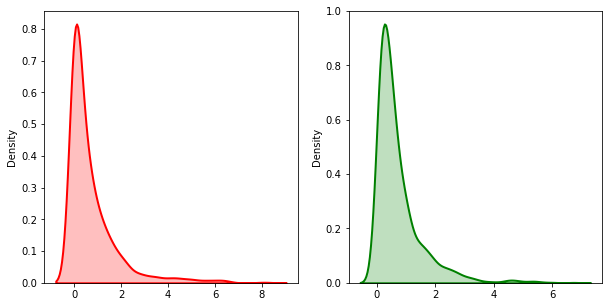

 Forest Regressor regression Predictions R2 : 61.0 | 94.0   Train Score

RED - Real data
GREEN - Predictid values


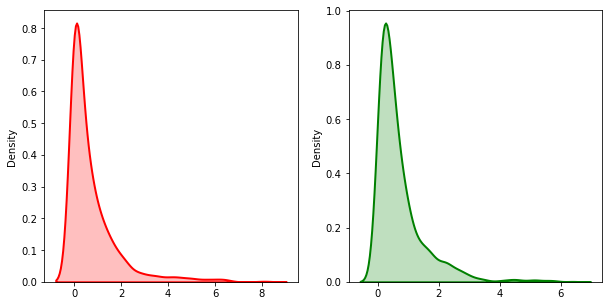

In [19]:
results, reg, rfr = multi_model(X_train, X_test, y_train, y_test)

#### Provided function to load a pickled model for further usage

In [20]:
# Import previously saved model
def import_model(path):
    import pickle
    return pickle.load(open(path, 'rb'))

# # Only needed to update the path and reutilize the model

# path = 'Models\\RFR_finalized_model.sav'
# model = import_model(path)